# Neural forecasting models

We will cover neural models for time series forecasting, both trained from scratch and pretrained. We will use varied libraries, depending on the model, for example:
- [sktime](https://www.sktime.net/en/stable/index.html) - general time series processing
- [neuralforecast](https://github.com/Nixtla/neuralforecast) - a lot of neural models for time series, e.g. DLinear, N-BEATS
- [PyTorch](https://pytorch.org/) - deep learning framework
- [timesfm](https://github.com/google-research/timesfm) - official TimesFM implementation (and loading pretrained model)

Use tutorials, quickstarts, GitHub pages etc. of those libraries as necessary.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Datasets and evaluation

We will use 2 datasets:
1. [Italian pasta dataset](https://www.sciencedirect.com/science/article/abs/pii/S0957417421005431?via%3Dihub), same as in the first notebook.
2. [Polish energy production data](https://energy.instrat.pl/en/electrical-system/electricity-production-are/), as published by Energy Instrat and ENTSO-e, from data by PSE (Polskie Sieci Elektroenergetyczne).

Both are multivariate and focused on long-term forecasting.

### Italian pasta

#### Data loading and visualization

This dataset technically multivariate, but it has data from 4 different companies with very different characteristics, so it may have pretty weak cross-series dependencies. We will consider a simplified variant with no exogenous variables.

In [2]:
from sktime.utils.plotting import plot_series


df_pasta = pd.read_csv("italian_pasta.csv")
for num in [1, 2, 3, 4]:
    company_qty_cols = [col for col in df_pasta.columns if col.startswith(f"QTY_B{num}")]
    df_pasta[f"value_B{num}"] = df_pasta[company_qty_cols].sum(axis="columns")

df_pasta = df_pasta.set_index(pd.to_datetime(df_pasta["DATE"])).asfreq("d")
df_pasta = df_pasta[["value_B1", "value_B2", "value_B3", "value_B4"]]
df_pasta

,value_B1,value_B2,value_B3,value_B4
DATE,,,,
2014-01-02,101.0,186.0,32.0,36.0
2014-01-03,136.0,248.0,32.0,27.0
2014-01-04,162.0,264.0,94.0,45.0
2014-01-05,106.0,106.0,18.0,29.0
2014-01-06,47.0,54.0,9.0,11.0
...,...,...,...,...
2018-12-27,203.0,143.0,30.0,39.0
2018-12-28,192.0,187.0,28.0,44.0
2018-12-29,158.0,217.0,44.0,48.0


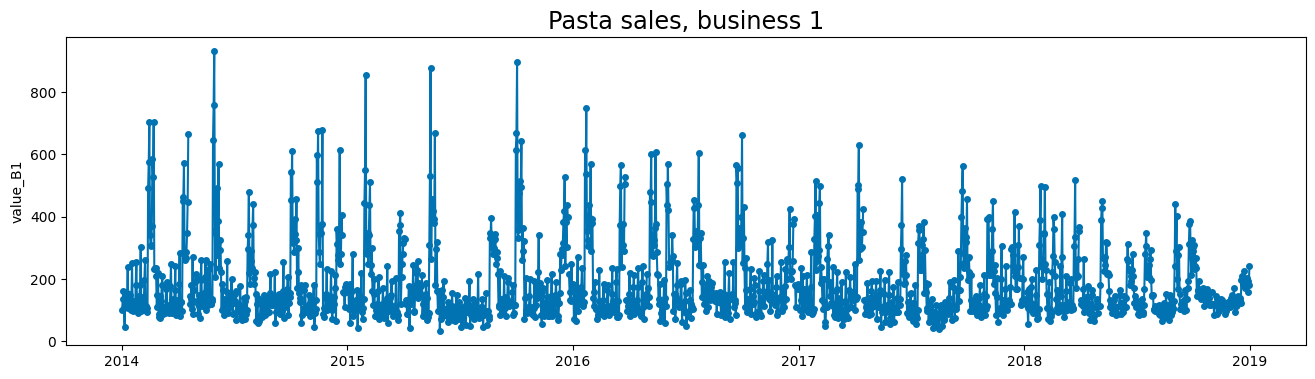

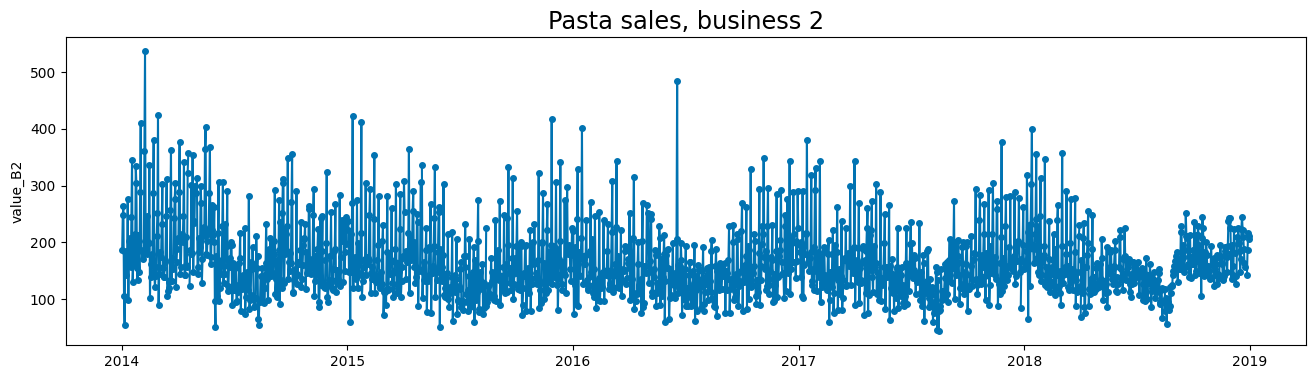

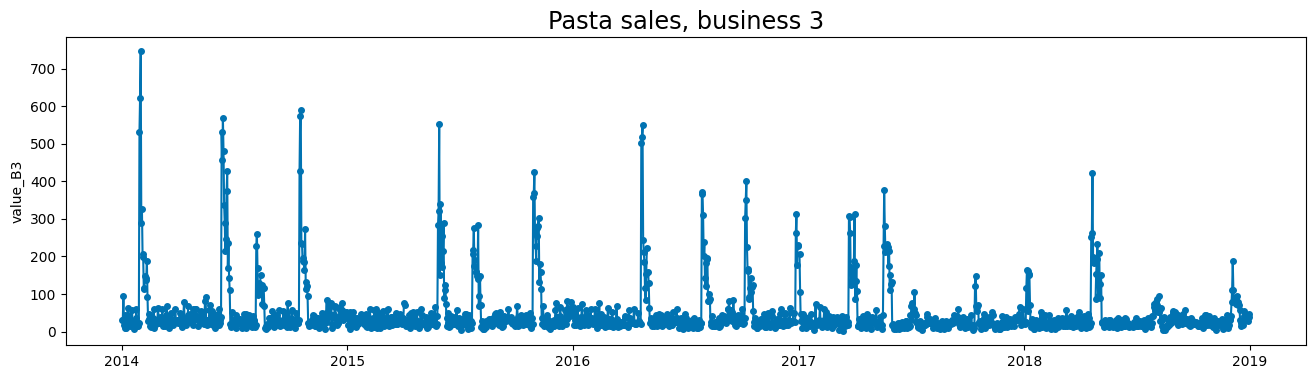

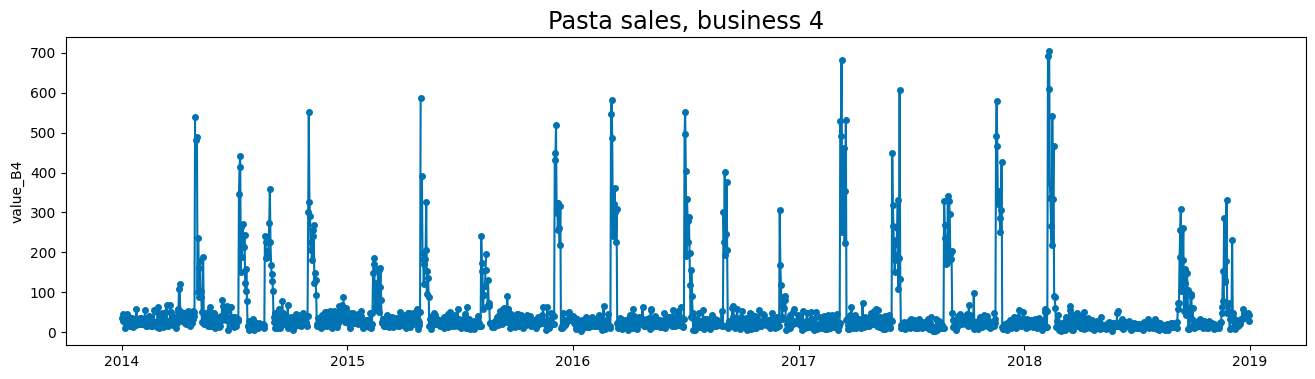

In [3]:
for num in [1, 2, 3, 4]:
    plot_series(df_pasta[f"value_B{num}"], title=f"Pasta sales, business {num}")


#### Evaluation

Similarly to the first notebook, we will be interested in long-term forecasting, predicting the daily sales for 2018, based on previous years. Since we have 4 time series with different scales, MASE is a great metric, since it can be averaged across series.

In [4]:
from sktime.transformations.series.impute import Imputer


df_pasta_train = df_pasta[df_pasta.index < "2018-01-01"]
df_pasta_test = df_pasta[df_pasta.index >= "2018-01-01"]

imputer = Imputer(method="ffill")
df_pasta_train = imputer.fit_transform(df_pasta_train)
df_pasta_test = imputer.transform(df_pasta_test)

print(f"Data size: train {len(df_pasta_train)}, test {len(df_pasta_test)}")

Data size: train 1460, test 365


### Polish energy production

#### Data loading and visualization

Energy mix is composed of multiple energy sources. It typically consists of multiple components:
- slow-changing base, e.g. coal, nuclear
- faster changing and controllable sources, e.g. gas, oil, hydro
- very cheap, but uncontrollably changing renewables, e.g. wind, solar

The resulting production is always limited by the grid efficiency, which is very low in Poland, resulting in e.g. refusing to connect more prosumer solar installations. As such, the production limits are monitored and controlled, and cross-series dependencies are often quite strong.

We will aggregate the energy sources a bit, and consider:
- coal (and derivatives)
- hydro (from all sources)
- solar
- wind
- all others, e.g. oil (petroleum), biomass

Since units are GWh (10^9 Wh, Whatt hours), values are very high, so we will consider thousands of GWh, i.e. TWh (10^12 Wh). It is not a standard unit, but should help with numerical stability for methods that do not perform standardization or scaling.

Data from PSE has changed its format and processing at 13.06.2024, and values since this date are in 15-minutes intervals, compared to 1-hour from before. As such, we divide them by 4, to have the same unit.

If you want to know more about energy production and demand, see e.g. [this video](https://www.youtube.com/watch?v=xhxo2oXRiio) or [this video](https://www.youtube.com/watch?v=GBp_NgrrtPM).

In [5]:
df_energy = pd.read_parquet("electricity_production_entsoe_all.parquet")
df_energy = df_energy.drop(columns="date_utc")
df_energy["date"] = pd.to_datetime(df_energy["date"], format="%d.%m.%Y %H:%M")
df_energy = df_energy.set_index("date")
df_energy = df_energy.resample("D").sum()

# aggregate energy sources
df_energy["coal"] = (
    df_energy["hard_coal"] + df_energy["coal-derived"] + df_energy["lignite"]
)
df_energy["hydro"] = (
    df_energy["hydro_pumped_storage"] + 
    df_energy["hydro_run-of-river_and_poundage"] + 
    df_energy["hydro_water_reservoir"]
)
df_energy["wind"] = df_energy["wind_onshore"]
df_energy["other"] = (
    df_energy["oil"] + 
    df_energy["biomass"] + 
    df_energy["other"] + 
    df_energy["other_renewable"]
)
df_energy = df_energy[["coal", "gas", "hydro", "wind", "solar", "other"]]

# fix values and change units (GWh -> thousands of GWh)
df_energy[df_energy.index >= "13.06.2024"] /= 4
df_energy["other"][df_energy.index >= "13.06.2024"] /= 2
df_energy = df_energy / 1000

# end at August 2025, later data has artifacts / yet another change - too early to know
df_energy = df_energy[df_energy.index < "2025.10.01"]

df_energy

,coal,gas,hydro,wind,solar,other
date,,,,,,
2015-01-02,298.904000,10.138000,9.255000,77.611000,0.000000,5.702000
2015-01-03,288.792000,10.259000,9.304000,80.985000,0.000000,5.155000
2015-01-04,271.662000,9.896000,7.838000,77.096000,0.000000,4.175000
2015-01-05,367.483000,10.030000,7.090000,43.309000,0.000000,5.627000
2015-01-06,343.572000,10.267000,7.068000,18.499000,0.000000,5.631000
...,...,...,...,...,...,...
2025-09-26,208.902355,53.682488,6.260815,116.993777,64.119360,12.966578
2025-09-27,177.579753,54.069982,5.355248,84.375545,71.341048,13.051972
2025-09-28,185.166142,57.371060,5.380583,48.741497,56.317910,12.712066


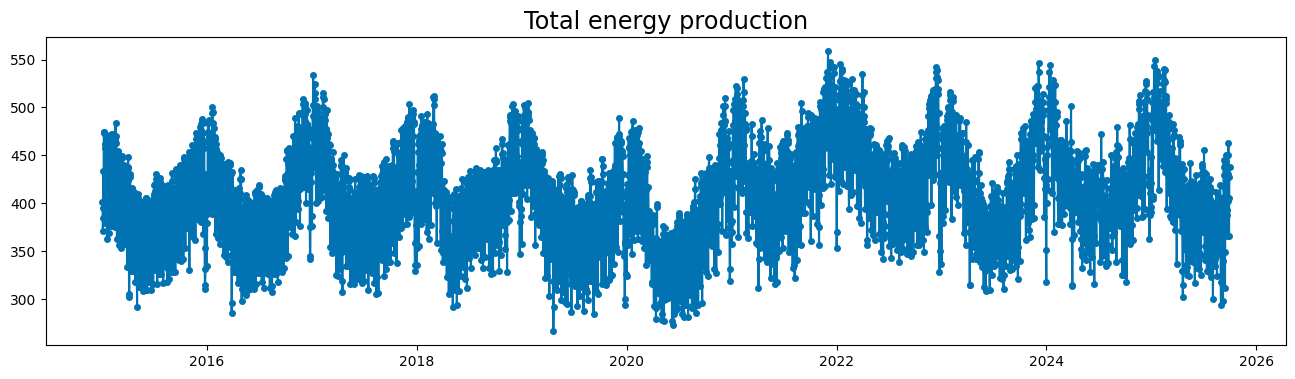

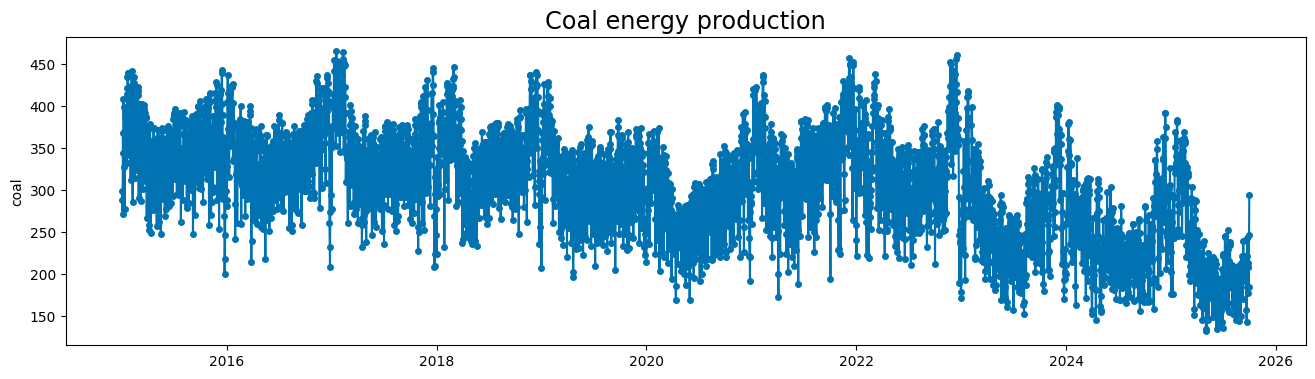

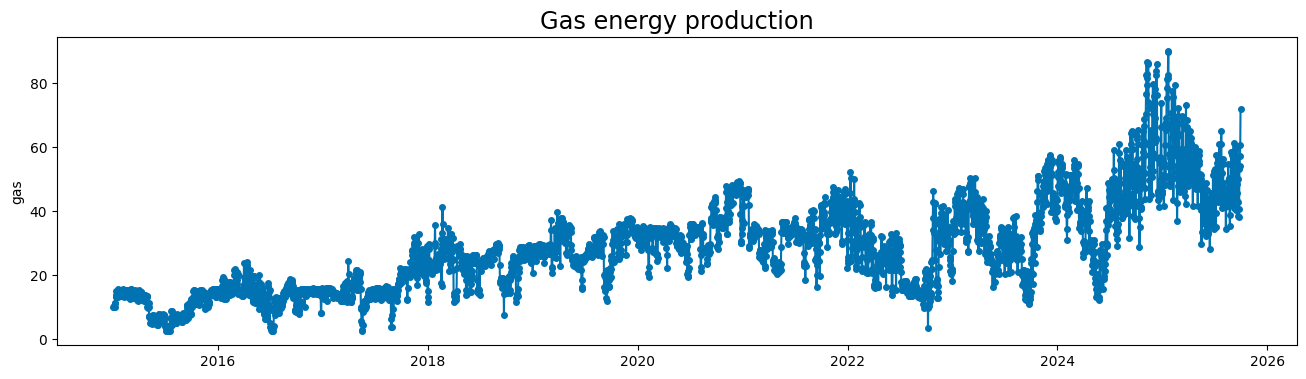

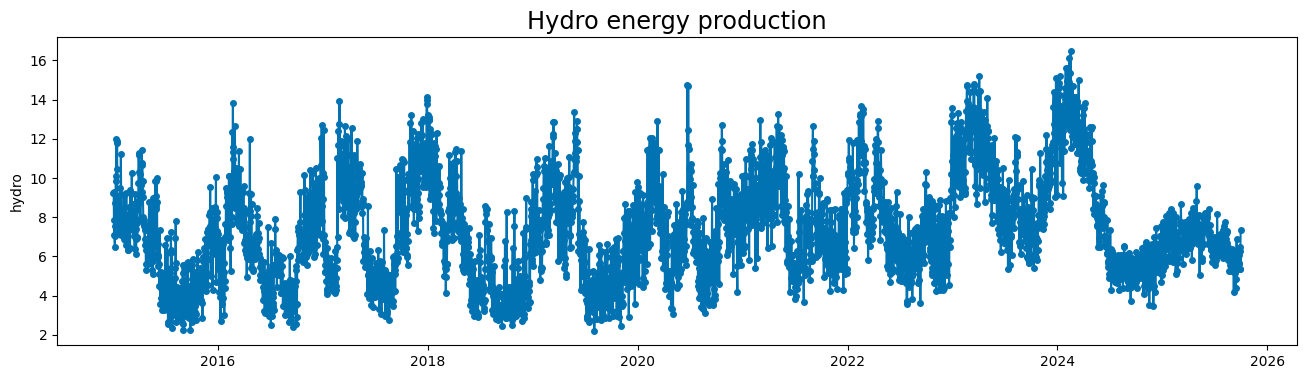

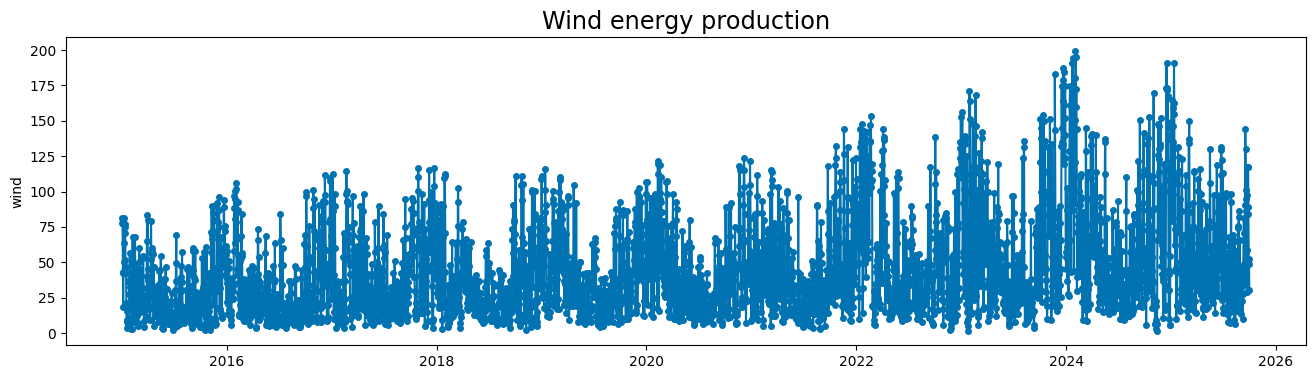

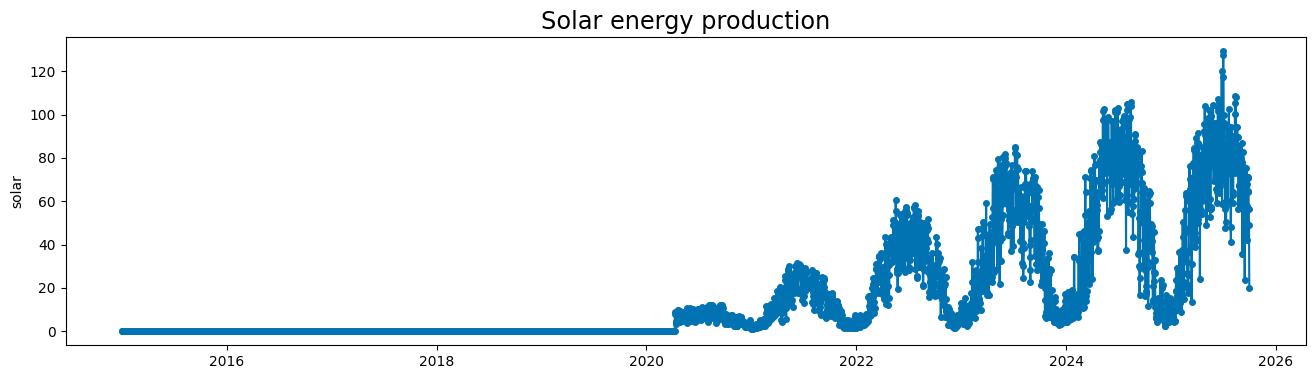

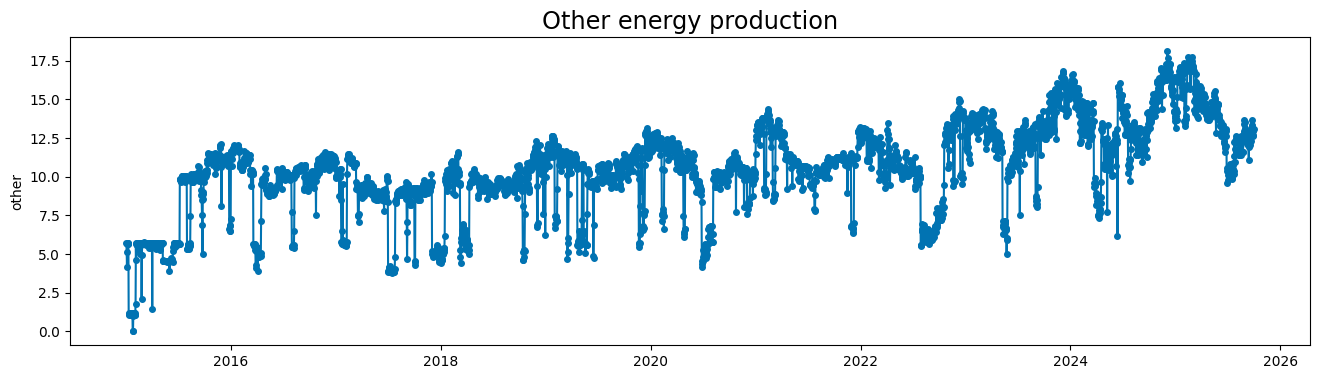

In [6]:
plot_series(df_energy.sum(axis="columns"), title=f"Total energy production")

for col in df_energy.columns:
    plot_series(df_energy[col], title=f"{col.capitalize()} energy production")


#### Evaluation

We will perform long-term forecasting, which is a common task on energy production and demand datasets. We will predict production for 2024, using MASE metric.

In [7]:
from sktime.transformations.series.impute import Imputer


df_energy_train = df_energy[df_energy.index < "2024-01-01"]
df_energy_test = df_energy[df_energy.index >= "2024-01-01"]

print(f"Data size: train {len(df_energy_train)}, test {len(df_energy_test)}")

Data size: train 3286, test 639


## Forecasting

The sub-sections are independent, and can be implemented in any order. The more you do, the more points (and hence the higher mark) you get. They are also more freeform than previous notebook, and there are more options to choose from.

When tuning hyperparameters, choose any strategy you think is reasonable, taking into consideration computational cost and model complexity. Temporal train-valid-test split, time split CV, expanding window - your choice. Even manual tuning is ok, if you think it makes sense, but remember to use the validation set.

You can use any framework and tool you want, but suggestions are provided in further sections. Install additional dependencies as needed, recommended way is using `uv add ...` or modyfing `pyproject.toml` and calling `uv sync`.

Training and evaluating more models from particular category can get you more points, as described below. If you prefer, you can also experiment with other models, e.g. RNNs, CNN-based, or state-space models (SSMs), adding further sections. Each one by default is worth 2 points.

**Warning:** when making this notebook, some errors with `neuralforecast` cropped up when horizon was greater than 292 for Italian pasta dataset. You can cut the test set at 292 if necessary.

Note that some frameworks (e.g. `neuralforecast`) require "tall"/"long" time series representation, with columns: `unique_id` (time series identifier), `ds` (date) and `y` (actual value). This is in contrast to the "wide" representation, where we have individual series in separate columns, each row with separate date, and values in cells. See e.g. [neuralforecast quickstart](https://nixtlaverse.nixtla.io/neuralforecast/docs/getting-started/quickstart.html#2-loading-airpassengers-data) for an example. Functions prepared below may be useful.

In [8]:
from typing import Optional


def wide_to_long_df(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.melt(df, ignore_index=False).reset_index(names="date")
    df = df.rename(columns={"variable": "unique_id", "date": "ds", "value": "y"})
    return df


def long_to_wide_df(df: pd.DataFrame, values_col: Optional[str] = None) -> pd.DataFrame:
    if "unique_id" not in df.columns:
        df = df.reset_index(names="unique_id")

    values_col = values_col if values_col else df.columns[-1]
    df = pd.pivot(df, columns="unique_id", index="ds", values=values_col)
    return df


### Baselines (2 points)

Implement baselines for neural models:
- last value (naive)
- average
- AutoARIMA
- AutoETS (with damped trend)

Each dataset is worth 1 point. `sktime` will be useful.

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError

mase = MeanAbsoluteScaledError()

def evaluate_forecaster(forecaster, train, test, name, dataset_name):
    forecaster.fit(train)
    fh = range(1, len(test) + 1)
    y_pred = forecaster.predict(fh=fh)
    
    results = {
        col: mase(test[col], y_pred[col], y_train=train[col])
        for col in train.columns
    }
    
    avg_mase = np.mean(list(results.values()))
    print(f"{name} on {dataset_name} - Avg MASE: {avg_mase:.4f}")
    print("\n".join(f"  {col}: {score:.4f}" for col, score in results.items()))
    return avg_mase, results

datasets = {
    "pasta": {
        "train": df_pasta_train,
        "test": df_pasta_test,
        "name": "Italian Pasta",
    },
    "energy": {
        "train": df_energy_train,
        "test": df_energy_test,
        "name": "Polish Energy",
    },
}

model_configs = [
    ("Naive", "Naive (Last Value)", lambda: NaiveForecaster(strategy="last")),
    ("Mean", "Mean", lambda: NaiveForecaster(strategy="mean")),
    ("AutoARIMA", "AutoARIMA", lambda: AutoARIMA(sp=7, suppress_warnings=True, max_order=5)),
    ("AutoETS", "AutoETS (damped)", lambda: AutoETS(auto=True, sp=7, damped_trend=True)),
]

baseline_results = {ds_key: {} for ds_key in datasets}

for ds_key, ds_data in datasets.items():
    print("=" * 20 + f" {ds_data['name']} Dataset " + "=" * 20)
    
    for model_key, model_name, model_factory in model_configs:
        model = model_factory()
        baseline_results[ds_key][model_key] = evaluate_forecaster(
            model, ds_data["train"], ds_data["test"], model_name, ds_data["name"]
        )[0]
    
    print()

print("=" * 20 + " Summary (Average MASE) " + "=" * 20)
print(pd.DataFrame(baseline_results))



==================== Italian Pasta Dataset ====================
Naive (Last Value) on Italian Pasta - Avg MASE: 0.9117
  value_B1: 0.8725
  value_B2: 0.6173
  value_B3: 0.9199
  value_B4: 1.2373
Mean on Italian Pasta - Avg MASE: 1.2576
  value_B1: 1.0765
  value_B2: 0.6454
  value_B3: 1.4989
  value_B4: 1.8094
AutoARIMA on Italian Pasta - Avg MASE: 1.4037
  value_B1: 1.7314
  value_B2: 0.6873
  value_B3: 1.3789
  value_B4: 1.8173


/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jwasieleski/Prywatne/jul/workspace/uczenie-maszynowe/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AutoETS (damped) on Italian Pasta - Avg MASE: 3.7701
  value_B1: 11.5236
  value_B2: 0.7697
  value_B3: 0.9234
  value_B4: 1.8635

==================== Polish Energy Dataset ====================
Naive (Last Value) on Polish Energy - Avg MASE: 6.5183
  coal: 1.4021
  gas: 6.0838
  hydro: 3.8071
  wind: 1.8315
  solar: 20.0732
  other: 5.9119
Mean on Polish Energy - Avg MASE: 8.4716
  coal: 2.8979
  gas: 12.4389
  hydro: 1.6025
  wind: 1.8379
  solar: 21.8537
  other: 10.1984
AutoARIMA on Polish Energy - Avg MASE: 7.3884
  coal: 3.8636
  gas: 7.5474
  hydro: 3.8050
  wind: 2.6456
  solar: 21.2929
  other: 5.1759
AutoETS (damped) on Polish Energy - Avg MASE: 11.5499
  coal: 1.4610
  gas: 5.3041
  hydro: 4.3997
  wind: 31.0593
  solar: 20.6845
  other: 6.3908

==================== Summary (Average MASE) ====================
              pasta     energy
Naive      0.911743   6.518272
Mean       1.257558   8.471555
AutoARIMA  1.403721   7.388429
AutoETS    3.770050  11.549884


**Comment:**

For the pasta dataset, Naive (last value) is the best at MASE=0.91, beating AutoARIMA (1.40) and AutoETS (3.77). Mean baseline gets 1.26. Similar to what we saw in the first notebook, simple baselines are hard to beat on pasta sales data.

For the energy dataset, Naive is also best at MASE=6.52, followed by AutoARIMA (7.39). The solar series is particularly hard to forecast (MASE around 20-21), which makes sense given how variable solar production is depending on weather.

These baseline numbers will be useful to compare against the neural models we train next.


### Linear models (2 points)

Implement linear neural models:
- multioutput linear regression
- LTSF Linear
- LTSF DLinear
- LTSF NLinear

Note that Linear is a multi-channel model, while multioutput linear regression is single-channel.

Tune the lookback window, the only hyperparameter of those models, or justify your choice in a comment if you don't. You can check the papers for reasonable values.

If you use a given model, train it on both datasets. Each model is worth 0.5 points. Useful libraries: `sktime`, `neuralforecast`, PyTorch.

Useful references:
- ["Are Transformers Effective for Time Series Forecasting?" A. Zeng et al.](https://arxiv.org/abs/2205.13504) ([GitHub code](https://github.com/cure-lab/LTSF-Linear))
- ["An Analysis of Linear Time Series Forecasting Models" W.Toner, L. Darlow](https://arxiv.org/abs/2403.14587) ([GitHub code](https://github.com/sir-lab/linear-forecasting))

In [10]:
from neuralforecast import NeuralForecast
from neuralforecast.models import DLinear, NLinear
from sklearn.linear_model import Ridge
LOOKBACK = 28


def evaluate_multioutput_lr(train, test, lookback):
    horizon = len(test)
    predictions = {}
    
    for col in train.columns:
        X_tr = np.array([train[col].iloc[i-lookback:i].values for i in range(lookback, len(train))])
        y_tr = train[col].iloc[lookback:].values
    
        model = Ridge(alpha=1.0).fit(X_tr, y_tr)
        last_window = train[col].iloc[-lookback:].values.copy()
        preds = []
        for _ in range(horizon):
            pred = model.predict(last_window.reshape(1, -1))[0]
            preds.append(pred)
            last_window = np.roll(last_window, -1)
            last_window[-1] = pred
        predictions[col] = preds
    
    return pd.DataFrame(predictions, index=test.index)

def evaluate_neuralforecast_model(model, train, test, horizon):
    train_long = wide_to_long_df(train)
    nf = NeuralForecast(models=[model], freq='D')
    nf.fit(df=train_long, val_size=horizon)
    
    preds = nf.predict()
    preds_wide = long_to_wide_df(preds)
    preds_wide.index = test.index[:horizon]
    return preds_wide


def compute_mase_results(train, test, predictions, model_name, dataset_name):
    results = {
        col: mase(test[col], predictions[col], y_train=train[col])
        for col in train.columns if col in predictions.columns
    }
    avg_mase = np.mean(list(results.values()))
    print(f"{model_name} on {dataset_name} - Avg MASE: {avg_mase:.4f}")
    print("\n".join(f"  {col}: {score:.4f}" for col, score in results.items()))
    return avg_mase

In [ ]:
datasets_config = {
    "pasta": {
        "train": df_pasta_train,
        "test": df_pasta_test,
        "horizon": min(len(df_pasta_test), 292),
        "name": "Pasta",
    },
    "energy": {
        "train": df_energy_train,
        "test": df_energy_test,
        "horizon": len(df_energy_test),
        "name": "Energy",
    },
} 

nf_model_configs = [
    ("DLinear", lambda h, lookback: DLinear(
        h=h, input_size=lookback, max_steps=500, 
        scaler_type='standard', early_stop_patience_steps=10
    )),
    ("NLinear", lambda h, lookback: NLinear(
        h=h, input_size=lookback, max_steps=500, 
        scaler_type='standard', early_stop_patience_steps=10
    )),
]

linear_results = {ds_key: {} for ds_key in datasets_config}

for ds_key, ds in datasets_config.items():
    train, test, horizon, name = ds["train"], ds["test"], ds["horizon"], ds["name"]
    test_subset = test.iloc[:horizon]
    
    print("=" * 20 + f" {name} Dataset " + "=" * 20)
    
    preds = evaluate_multioutput_lr(train, test_subset, LOOKBACK)
    linear_results[ds_key]["MultiOutput_LR"] = compute_mase_results(
        train, test_subset, preds, "Multioutput LR", name
    )
    
    for model_name, model_factory in nf_model_configs:
        model = model_factory(horizon, LOOKBACK)
        preds = evaluate_neuralforecast_model(model, train, test, horizon)
        linear_results[ds_key][model_name] = compute_mase_results(
            train, test_subset, preds, model_name, name
        )
    
    print()

print("=" * 20 + " Summary (Average MASE) " + "=" * 20)
print(pd.DataFrame(linear_results))


Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name          | Type          | Params | Mode  | FLOPs
----------------------------------------------------------------
0 | loss          | MAE           | 0      | train | 0    
1 | padder_train  | ConstantPad1d | 0      | train | 0    
2 | scaler        | TemporalNorm  | 0      | train | 0    
3 | decomp        | SeriesDecomp  | 0      | train | 0    
4 | linear_trend  | Linear        | 8.5 K  | train | 0    
5 | linear_season | Linear        | 8.5 K  | train | 0    
----------------------------------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
0         Total Flops


==================== Pasta Dataset ====================
Multioutput LR on Pasta - Avg MASE: 1.3097
  value_B1: 1.1186
  value_B2: 0.6265
  value_B3: 1.5769
  value_B4: 1.9169


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MAE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | linear       | Linear        | 8.5 K  | train | 0    
---------------------------------------------------------------
8.5 K     Trainable params
0         Non-trainable params
8.5 K     Total params
0.034     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
0         Total Flops


DLinear on Pasta - Avg MASE: 1.0298
  value_B1: 1.2103
  value_B2: 0.7654
  value_B3: 0.9811
  value_B4: 1.1625


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

NLinear on Pasta - Avg MASE: 1.0643
  value_B1: 1.2712
  value_B2: 0.7827
  value_B3: 0.9996
  value_B4: 1.2036

==================== Energy Dataset ====================


Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name          | Type          | Params | Mode  | FLOPs
----------------------------------------------------------------
0 | loss          | MAE           | 0      | train | 0    
1 | padder_train  | ConstantPad1d | 0      | train | 0    
2 | scaler        | TemporalNorm  | 0      | train | 0    
3 | decomp        | SeriesDecomp  | 0      | train | 0    
4 | linear_trend  | Linear        | 18.5 K | train | 0    
5 | linear_season | Linear        | 18.5 K | train | 0    
----------------------------------------------------------------
37.1 K    Trainable params
0         Non-trainable params
37.1 K    Total params
0.148     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
0         Total Flops


Multioutput LR on Energy - Avg MASE: 7.4967
  coal: 2.5998
  gas: 9.6031
  hydro: 1.2815
  wind: 1.7523
  solar: 21.2365
  other: 8.5071


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MAE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | linear       | Linear        | 18.5 K | train | 0    
---------------------------------------------------------------
18.5 K    Trainable params
0         Non-trainable params
18.5 K    Total params
0.074     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
0         Total Flops


DLinear on Energy - Avg MASE: 7.1351
  coal: 1.9678
  gas: 5.3726
  hydro: 3.7701
  wind: 3.0464
  solar: 22.3216
  other: 6.3319


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

NLinear on Energy - Avg MASE: 6.9788
  coal: 1.7965
  gas: 5.5503
  hydro: 3.8131
  wind: 2.7480
  solar: 21.7095
  other: 6.2552

==================== Summary (Average MASE) ====================
                   pasta    energy
MultiOutput_LR  1.309728  7.496709
DLinear         1.029825  7.135085
NLinear         1.064295  6.978775


### MLP-based models (2 points)

Implement MLP-based neural models:
- N-BEATS
- TSMixer

For N-BEATS, use the interpretable architecture variant. If you want to tune hyperparameters, you can use e.g. automated class from `neuralforecast` with Ray or Optuna frameworks.

Training each model on each dataset is worth 0.5 points. Useful libraries: `neuralforecast`, PyTorch, `pytorch-tsmixer`.

Other interesting MLP-based models are e.g. N-HiTS, TiDE, TimeMixer, SOFTS. Each additional model is graded like models above.

Useful references:
- ["N-BEATS: Neural basis expansion analysis for interpretable time series forecasting" B. Oreshkin et al.](https://arxiv.org/abs/1905.10437)
- ["TSMixer: An All-MLP Architecture for Time Series Forecasting" S. Chen et al.](https://arxiv.org/abs/2303.06053)
- ["N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting" C. Challu et al.](https://arxiv.org/abs/2201.12886)
- ["Long-term Forecasting with TiDE: Time-series Dense Encoder" A. Das et al.](https://arxiv.org/abs/2304.08424)
- ["TimeMixer: Decomposable Multiscale Mixing for Time Series Forecasting" S. Wang et al.](https://arxiv.org/abs/2405.14616)
- ["SOFTS: Efficient Multivariate Time Series Forecasting with Series-Core Fusion" L. Han et al.](https://arxiv.org/abs/2404.14197)
- [neuralforecast forecasting models list](https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/overview.html)

In [ ]:
from neuralforecast.models import NBEATS, TSMixer

mlp_model_configs = [
    ("NBEATS", lambda h, lookback, n_series: NBEATS(
        h=h, input_size=lookback, max_steps=500, scaler_type='standard',
        stack_types=['trend', 'seasonality'], n_blocks=[3, 3],
        mlp_units=[[256, 256], [256, 256]], n_harmonics=2, n_polynomials=3,
        early_stop_patience_steps=10,
    )),
    ("TSMixer", lambda h, lookback, n_series: TSMixer(
        h=h, input_size=lookback, n_series=n_series, max_steps=500,
        scaler_type='standard', n_block=2, ff_dim=64, dropout=0.1,
        early_stop_patience_steps=10,
    )),
]

mlp_results = {ds_key: {} for ds_key in datasets_config}

for ds_key, ds in datasets_config.items():
    train, test, horizon, name = ds["train"], ds["test"], ds["horizon"], ds["name"]
    test_subset = test.iloc[:horizon]
    n_series = len(train.columns)
    
    print("=" * 20 + f" {name} Dataset " + "=" * 20)
    
    for model_name, model_factory in mlp_model_configs:
        model = model_factory(horizon, LOOKBACK, n_series)
        preds = evaluate_neuralforecast_model(model, train, test, horizon)
        mlp_results[ds_key][model_name] = compute_mase_results(
            train, test_subset, preds, model_name, name
        )
    
    print()

print("=" * 20 + " Summary (Average MASE) " + "=" * 20)
print(pd.DataFrame(mlp_results))


Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MAE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 2.3 M  | train | 0    
---------------------------------------------------------------
1.7 M     Trainable params
561 K     Non-trainable params
2.3 M     Total params
9.191     Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode
0         Total Flops


==================== Pasta Dataset ====================


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name          | Type              | Params | Mode  | FLOPs
--------------------------------------------------------------------
0 | loss          | MAE               | 0      | train | 0    
1 | padder_train  | ConstantPad1d     | 0      | train | 0    
2 | scaler        | TemporalNorm      | 0      | train | 0    
3 | norm          | RevINMultivariate | 8      | train | 0    
4 | mixing_layers | Sequential        | 3.7 K  | train | 0    
5 | out           | Linear            | 8.5 K  | train | 0    
--------------------------------------------------------------------
12.2 K    Trainable params
0         Non-trainable params
12.2 K    Total params
0.049     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
0         Total Flops


NBEATS on Pasta - Avg MASE: 0.9303
  value_B1: 0.9789
  value_B2: 0.6533
  value_B3: 0.9569
  value_B4: 1.1320


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name         | Type          | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | loss         | MAE           | 0      | train | 0    
1 | padder_train | ConstantPad1d | 0      | train | 0    
2 | scaler       | TemporalNorm  | 0      | train | 0    
3 | blocks       | ModuleList    | 5.4 M  | train | 0    
---------------------------------------------------------------
2.8 M     Trainable params
2.6 M     Non-trainable params
5.4 M     Total params
21.462    Total estimated model params size (MB)
52        Modules in train mode
0         Modules in eval mode
0         Total Flops


TSMixer on Pasta - Avg MASE: 0.9328
  value_B1: 1.0161
  value_B2: 0.6917
  value_B3: 0.9023
  value_B4: 1.1209

==================== Energy Dataset ====================


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name          | Type              | Params | Mode  | FLOPs
--------------------------------------------------------------------
0 | loss          | MAE               | 0      | train | 0    
1 | padder_train  | ConstantPad1d     | 0      | train | 0    
2 | scaler        | TemporalNorm      | 0      | train | 0    
3 | norm          | RevINMultivariate | 12     | train | 0    
4 | mixing_layers | Sequential        | 4.6 K  | train | 0    
5 | out           | Linear            | 18.5 K | train | 0    
--------------------------------------------------------------------
23.2 K    Trainable params
0         Non-trainable params
23.2 K    Total params
0.093     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode
0         Total Flops


NBEATS on Energy - Avg MASE: 6.6504
  coal: 1.1539
  gas: 5.6705
  hydro: 2.5689
  wind: 5.4100
  solar: 19.9779
  other: 5.1214


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

TSMixer on Energy - Avg MASE: 7.4045
  coal: 2.9681
  gas: 5.3810
  hydro: 4.2331
  wind: 3.4798
  solar: 21.2512
  other: 7.1139

==================== Summary (Average MASE) ====================
            pasta    energy
NBEATS   0.930255  6.650417
TSMixer  0.932751  7.404510


### Time series transformers (2 points)

Implement a time series transformer, e.g. PatchTST.

You can use either pretrained variant, or train from scratch. If you want to tune hyperparameters, you can use e.g. automated class from `neuralforecast` with Ray or Optuna frameworks.

Training the model in any way is worth 2 points. You can also choose any other time series transformer, e.g. TFT, iTransformer, Autoformer. Useful libraries: `neuralforecast`, PyTorch, `transformers`, IBM Granite. Each model after the first one is worth 1 point. If you use PatchTST, using the pretrained one and training from scratch counts as two separate models.

Useful references:
- ["A Time Series is Worth 64 Words: Long-term Forecasting with Transformers" Y. Nie et al.](https://arxiv.org/abs/2211.14730)
- ["Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting" B. Lim et al.](https://arxiv.org/abs/1912.09363)
- ["iTransformer: Inverted Transformers Are Effective for Time Series Forecasting" Y. Liu et al.](https://arxiv.org/abs/2310.06625)
- ["Autoformer: Decomposition Transformers with Auto-Correlation for Long-Term Series Forecasting" H. Wu et al.](https://arxiv.org/abs/2106.13008)
- [neuralforecast forecasting models list](https://nixtlaverse.nixtla.io/neuralforecast/docs/capabilities/overview.html)
- [IBM Granite tutorial for pretrained PatchTST](https://github.com/ibm-granite/granite-tsfm/blob/main/notebooks/hfdemo/patch_tst_getting_started.ipynb)

In [ ]:
from neuralforecast.models import PatchTST, iTransformer

transformer_model_configs = [
    ("PatchTST", lambda h, lookback, n_series: PatchTST(
        h=h, input_size=lookback, max_steps=500, 
        patch_len=16, stride=8, encoder_layers=2,
    )),
    ("iTransformer", lambda h, lookback, n_series: iTransformer(
        h=h, input_size=lookback, n_series=n_series, max_steps=500,
        e_layers=2,
    )),
]

transformer_results = {ds_key: {} for ds_key in datasets_config}

for ds_key, ds in datasets_config.items():
    train, test, horizon, name = ds["train"], ds["test"], ds["horizon"], ds["name"]
    test_subset = test.iloc[:horizon]
    n_series = len(train.columns)
    
    print("=" * 20 + f" {name} Dataset " + "=" * 20)
    
    for model_name, model_factory in transformer_model_configs:
        model = model_factory(horizon, LOOKBACK, n_series)
        preds = evaluate_neuralforecast_model(model, train, test, horizon)
        transformer_results[ds_key][model_name] = compute_mase_results(
            train, test_subset, preds, model_name, name
        )
    
    print()

print("=" * 20 + " Summary (Average MASE) " + "=" * 20)
print(pd.DataFrame(transformer_results))


Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | MAE               | 0      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 379 K  | train | 0    
-------------------------------------------------------------------
379 K     Trainable params
2         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
65        Modules in train mode
0         Modules in eval mode
0         Total Flops


==================== Pasta Dataset ====================


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name          | Type                   | Params | Mode  | FLOPs
-------------------------------------------------------------------------
0 | loss          | MAE                    | 0      | train | 0    
1 | padder_train  | ConstantPad1d          | 0      | train | 0    
2 | scaler        | TemporalNorm           | 0      | train | 0    
3 | enc_embedding | DataEmbedding_inverted | 14.8 K | train | 0    
4 | encoder       | TransEncoder           | 6.3 M  | train | 0    
5 | projector     | Linear                 | 149 K  | train | 0    
-------------------------------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
25.882    Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode
0         Total Flops


PatchTST on Pasta - Avg MASE: 0.9379
  value_B1: 1.0286
  value_B2: 0.6977
  value_B3: 0.9025
  value_B4: 1.1227


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name         | Type              | Params | Mode  | FLOPs
-------------------------------------------------------------------
0 | loss         | MAE               | 0      | train | 0    
1 | padder_train | ConstantPad1d     | 0      | train | 0    
2 | scaler       | TemporalNorm      | 0      | train | 0    
3 | model        | PatchTST_backbone | 513 K  | train | 0    
-------------------------------------------------------------------
513 K     Trainable params
2         Non-trainable params
513 K     Total params
2.054     Total estimated model params size (MB)
65        Modules in train mode
0         Modules in eval mode
0         Total Flops


iTransformer on Pasta - Avg MASE: 0.9160
  value_B1: 0.9876
  value_B2: 0.6716
  value_B3: 0.8974
  value_B4: 1.1074

==================== Energy Dataset ====================


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name          | Type                   | Params | Mode  | FLOPs
-------------------------------------------------------------------------
0 | loss          | MAE                    | 0      | train | 0    
1 | padder_train  | ConstantPad1d          | 0      | train | 0    
2 | scaler        | TemporalNorm           | 0      | train | 0    
3 | enc_embedding | DataEmbedding_inverted | 14.8 K | train | 0    
4 | encoder       | TransEncoder           | 6.3 M  | train | 0    
5 | projector     | Linear                 | 327 K  | train | 0    
-------------------------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.594    Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval mode
0         Total Flops


PatchTST on Energy - Avg MASE: 6.9406
  coal: 1.8911
  gas: 5.2251
  hydro: 3.5978
  wind: 2.2761
  solar: 22.5200
  other: 6.1335


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=500` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Predicting: |          | 0/? [00:00<?, ?it/s]

iTransformer on Energy - Avg MASE: 6.9768
  coal: 1.9514
  gas: 5.2750
  hydro: 3.4908
  wind: 2.4308
  solar: 22.7993
  other: 5.9134

==================== Summary (Average MASE) ====================
                 pasta    energy
PatchTST      0.937877  6.940604
iTransformer  0.915996  6.976781


### Pretrained foundation models (2 points)

Use a pretrained time series foundation model for zero-shot forecasting.

Examples are e.g. TimesFM, Lag-Llama, TimeGPT, Moirai. Model notes:
1. TimesFM - using the PyTorch version of original library is suggested
2. Lag-Llama - this is a probabilistic model, note that we are interested in point forecasts (mean probabilistic value)
3. TimeGPT - as this is a proprietary model, you need to provide the API token, make sure you don't push it to a public repository!

The first model is worth 2 points, and subsequent ones are worth 1 point each.

Useful references:
- ["A decoder-only foundation model for time-series forecasting" A. Das et al.](https://arxiv.org/abs/2310.10688)
- [TimesFM repository](https://github.com/google-research/timesfm)
- ["Lag-Llama: Towards Foundation Models for Probabilistic Time Series Forecasting" K. Rasul et al.](https://arxiv.org/abs/2310.08278)
- [Lag-Llama repository](https://github.com/time-series-foundation-models/lag-llama)
- ["TimeGPT-1" A. Garza et al.](https://arxiv.org/abs/2310.03589)
- [TimeGPT docs](https://docs.nixtla.io/)
- ["Unified Training of Universal Time Series Forecasting Transformers" G. Woo et al.](https://arxiv.org/abs/2402.02592)
- [HuggingFace Moirai model page](https://huggingface.co/Salesforce/moirai-1.0-R-large)

In [ ]:
# I had serious issiues with installing TimesFM, so I gave up at this point. 
# If it will be neccesary I will try again, but by now I just leave this part 
# and hope that I will have enough points to pass this lab
#I know I could use uv lock. Maybe will use it next time

FINAL SUMMARY: ALL MODELS 
                   pasta     energy
Naive           0.911743   6.518272
iTransformer    0.915996   6.976781
NBEATS          0.930255   6.650417
TSMixer         0.932751   7.404510
PatchTST        0.937877   6.940604
DLinear         1.029825   7.135085
NLinear         1.064295   6.978775
Mean            1.257558   8.471555
MultiOutput_LR  1.309728   7.496709
AutoARIMA       1.403721   7.388429
AutoETS         3.770050  11.549884


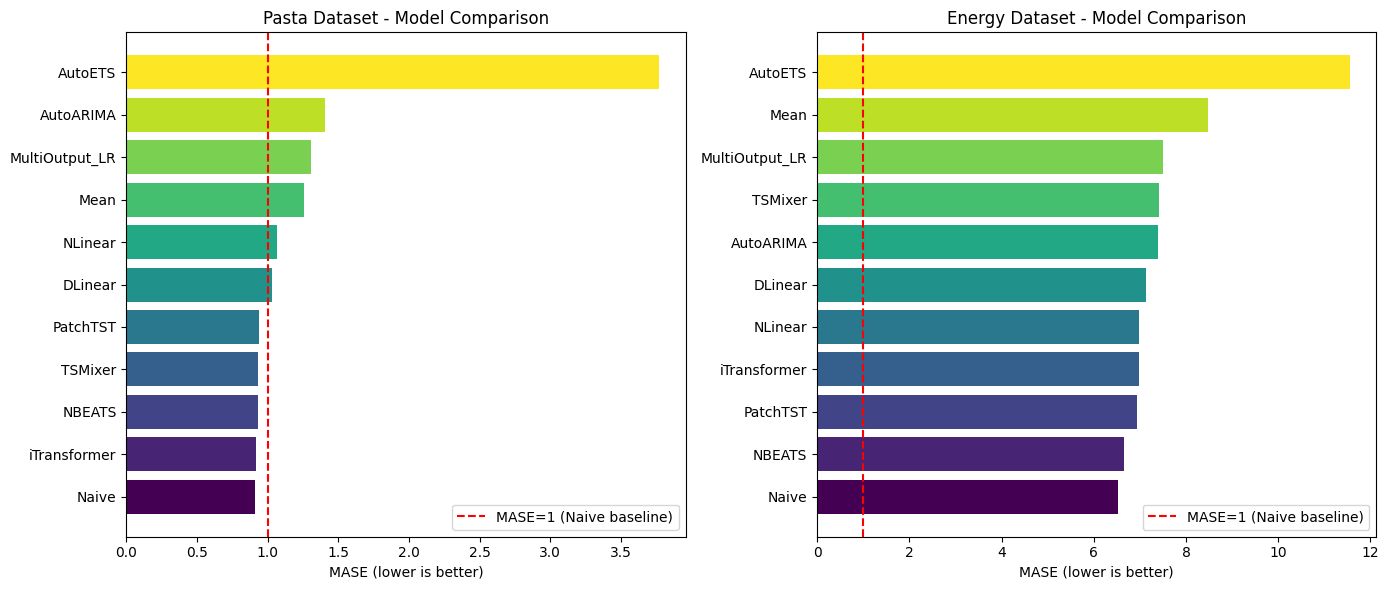

In [19]:
print("FINAL SUMMARY: ALL MODELS ")

all_results = {
    ds_key: {
        **baseline_results[ds_key],
        **linear_results[ds_key],
        **mlp_results[ds_key],
        **transformer_results[ds_key],
    }
    for ds_key in datasets_config
}

final_df = pd.DataFrame(all_results).sort_values(by="pasta")
print(final_df)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (ds_key, ds) in zip(axes, datasets_config.items()):
    data = final_df[ds_key].sort_values()
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))
    ax.barh(data.index, data.values, color=colors)
    ax.set_xlabel("MASE (lower is better)")
    ax.set_title(f"{ds['name']} Dataset - Model Comparison")
    ax.axvline(x=1.0, color='red', linestyle='--', label='MASE=1 (Naive baseline)')
    ax.legend()

plt.tight_layout()
plt.show()


**Comment:**

Looking at the final comparison table, the results are quite surprising. On both datasets, the simple Naive (last value) baseline is actually the best performer:
- Pasta: Naive MASE=0.91, followed closely by iTransformer (0.92), NBEATS (0.93), TSMixer (0.93)
- Energy: Naive MASE=6.52, followed by NBEATS (6.65), PatchTST (6.94), iTransformer (6.98)

The neural models (transformers and MLPs) come very close to the baseline but none of them actually beat it. What might be the reasons:
1. Long-horizon forecasting (292+ days) is difficult 
2. The pasta sales data has high volatility and weak cross-series dependencies
3. Neural models may need more hyperparameter tuning or more training data

The AutoETS and AutoARIMA statistical models performed worst here, which is expected for such long horizons where their uncertainty accumulates.

In practice, I would probably use the Naive baseline for these tasks since it is simpler and cheaper to run, unless there is a specific reason to believe neural models would help (like having more exogenous variables or shorter forecast horizons).
